# Imports

In [1]:
%load_ext extensions
%cd_repo_root

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/rubchume-gpu/code/Users/rubchume/VoiceCloningFakeAudioDetection'

In [2]:
from contextlib import contextmanager
import os
from pathlib import Path
import random
import re
import sys
from typing import Iterable, List

from azure.ai.ml import MLClient
from azureml.core import Workspace, Dataset as AzureCoreDataset, Datastore
from IPython.display import Audio
from azure.identity import DefaultAzureCredential
import mlflow
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from pydub import AudioSegment
import pytorch_lightning as pl
import torch
from torch.utils.data import Dataset
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

import directory_structure

# Utilities

In [3]:
def reproduce_audio_file_with_pydub(audio_file):
    audio = AudioSegment.from_file(audio_file)
    display(audio)
    

def reproduce_audio_from_pcm_samples(pcm_samples: np.array, sample_rate: int):
    audio = Audio(data=pcm_samples, rate=sample_rate, autoplay=True)
    display(audio)
    

def get_relative_path(origin, destination):
    go_up_path = "../"
    
    origin_absolute = Path(origin).resolve()
    destination_absolute = Path(destination).resolve()
    
    common_path = Path(os.path.commonpath([origin_absolute, destination_absolute]))
    from_origin_to_common_path = Path(go_up_path * (len(origin_absolute.parts) - len(common_path.parts)))
    from_common_path_to_destination = destination_absolute.relative_to(common_path)
    return from_origin_to_common_path / from_common_path_to_destination


@contextmanager
def suppress_error_print():
    original_stderr = sys.stderr
    sys.stderr = open(os.devnull, 'w')
    try:
        yield
    finally:
        sys.stderr.close()
        sys.stderr = original_stderr


def parse_datastore_uri(datastore_uri):
    match_object = re.match(
        r"^azureml://subscriptions/[^/]+/resourcegroups/[^/]+/workspaces/[^/]+/datastores/(?P<datastore>[^/]+)/paths/(?P<relative_path>.+)$",
        datastore_uri
    )

    datastore_name = match_object.group("datastore")
    relative_path = match_object.group("relative_path")
    return datastore_name, relative_path


def mount_data_asset(data_asset):
    datastore_name, relative_path = parse_datastore_uri(data_asset.path)
    workspace = Workspace.from_config()
    datastore = Datastore.get(workspace, datastore_name)
    dataset = AzureCoreDataset.File.from_files(path=(datastore, relative_path))
    return dataset.mount()


@contextmanager
def mounted_data_asset(data_asset):
    with suppress_error_print():
        mounted_path = mount_data_asset(data_asset)
        mounted_path.start()

    yield mounted_path.mount_point
    mounted_path.stop()
    
    
import itertools
import runpy


@contextmanager
def cli_arguments(**arguments):
    original_arguments = sys.argv
    sys.argv = kwargs_to_command_line_arguments(**arguments)
    try:
        yield
    finally:
        sys.argv = original_arguments


def kwargs_to_command_line_arguments(**kwargs):
    return [None] + list(itertools.chain.from_iterable([
        (f"--{key}", str(value))
        for key, value in kwargs.items()
    ]))

# Setup

In [4]:
experiment_name = "classification_wav2vec"

project_source_path = directory_structure.source_path / experiment_name
Path(project_source_path).mkdir(exist_ok=True, parents=True)

pipeline_path = directory_structure.job_definitions_path / experiment_name
Path(pipeline_path).mkdir(exist_ok=True, parents=True)

project_source_path_relative = get_relative_path(pipeline_path, project_source_path)

# Step: Prepare dataset

## Create scripts

In [5]:
real_voices_path = directory_structure.data_path / "Common Voice/cv-corpus-15-delta-2023-09-08/en"
real_voices_info_file = real_voices_path / "validated.tsv"

real_info = pd.read_csv(real_voices_info_file, delimiter="\t")["path"].map(
    lambda path: str(real_voices_path / "clips" / path)
)
cloned_info = pd.Series([str(path) for path in Path("outputs/OOTB-YourTTS/TIMITexamples/").glob("*.wav")]).rename("path")

In [6]:
prepare_data_script_name = "prepare_data.py"
prepare_data_path = str(project_source_path / prepare_data_script_name)
prepare_data_path_relative = get_relative_path(pipeline_path, prepare_data_path)

In [7]:
%%writefile {prepare_data_path}
import argparse
import inspect
from pathlib import Path

import pandas as pd


def make_command(function):
    parser = argparse.ArgumentParser()
    for parameter_name, parameter in inspect.signature(function).parameters.items():
        parser.add_argument(f"--{parameter_name}", type=parameter.annotation if parameter.annotation != inspect._empty else None)
    
    def wrapper():
        args = parser.parse_args()
        return function(**vars(args))
    
    return wrapper


def get_relative_path(origin, destination):
    go_up_path = "../"
    
    origin_absolute = Path(origin).resolve()
    destination_absolute = Path(destination).resolve()
    
    common_path = Path(os.path.commonpath([origin_absolute, destination_absolute]))
    from_origin_to_common_path = Path(go_up_path * (len(origin_absolute.parts) - len(common_path.parts)))
    from_common_path_to_destination = destination_absolute.relative_to(common_path)
    return from_origin_to_common_path / from_common_path_to_destination


@make_command
def main(common_voice_dataset, cloned_voice_dataset, real_voice_files, cloned_voice_files):
    real_voices_path = Path(common_voice_dataset) / "en"
    real_voices_info_file = Path(real_voices_path) / "validated.tsv"
    real_info = pd.read_csv(real_voices_info_file, delimiter="\t")["path"].map(
        lambda path: str(real_voices_path / "clips" / path)
    )
    
    cloned_info = pd.Series([str(path) for path in Path(cloned_voice_dataset).glob("*.wav")]).rename("path")
    
    real_info.str.removeprefix(common_voice_dataset).to_csv(real_voice_files, header=False, index=False)
    cloned_info.str.removeprefix(cloned_voice_dataset).to_csv(cloned_voice_files, header=False, index=False)
    

if __name__ == "__main__":
    main()

Overwriting src/classification_wav2vec/prepare_data.py


## Test scripts locally

In [8]:
# ml_client = MLClient.from_config(credential=DefaultAzureCredential())
# common_voice_data_asset = ml_client.data.get(name="CommonVoiceDeltaSegment15", label="latest")
# timit_cloned_data_asset = ml_client.data.get(name="TIMITClonedVoices", label="latest")

# with (
#     mounted_data_asset(common_voice_data_asset) as common_voice_mount_path,
#     mounted_data_asset(timit_cloned_data_asset) as timit_cloned_mount_path
# ):
#     with cli_arguments(
#         common_voice_dataset=common_voice_mount_path,
#         cloned_voice_dataset=timit_cloned_mount_path,
#         real_voice_files="mock_real_voices.csv",
#         cloned_voice_files="mock_cloned_voices.csv"
#     ):
#         runpy.run_path(prepare_data_path, run_name='__main__')

## Create component definition

### Environment

In [9]:
prepare_data_environment_name = "voice-classification-prepare-data-component-environment"

In [10]:
# !conda env export --name {Path(sys.executable).parent.parent.name} > {directory_structure.environments_path}/{prepare_data_environment_name}-conda.yaml

In [11]:
%%rendertemplate {directory_structure.environments_path}/{prepare_data_environment_name}.yaml
$schema: https://azuremlschemas.azureedge.net/latest/environment.schema.json
name: [[prepare_data_environment_name]]
image: mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04
conda_file: conda.yaml
description: Environment created for data preparation in voice classification

'job_definitions/environments/voice-classification-prepare-data-component-environment.yaml'

### Component definition

In [12]:
prepare_data_component_name = "prepare_data_component.yaml"

In [13]:
%%rendertemplate {pipeline_path}/{prepare_data_component_name}
$schema: https://azuremlschemas.azureedge.net/latest/commandComponent.schema.json
type: command

name: prepare_data
display_name: Prepare data

inputs:
    common_voice_dataset:
        type: uri_folder
    cloned_voice_dataset:
        type: uri_folder

outputs:
    real_voice_files:
        type: uri_file
    cloned_voice_files:
        type: uri_file

code: [[project_source_path_relative]]
command: >-
    python [[prepare_data_script_name]]
    --common_voice_dataset ${{inputs.common_voice_dataset}}
    --cloned_voice_dataset ${{inputs.cloned_voice_dataset}}
    --real_voice_files ${{outputs.real_voice_files}}
    --cloned_voice_files ${{outputs.cloned_voice_files}}

environment: azureml:[[prepare_data_environment_name]]@latest

'job_definitions/classification_wav2vec/prepare_data_component.yaml'

# Step: Train detector

## Create scripts

### Dataset

In [14]:
%%writefile {project_source_path}/audio_binary_dataset.py
import random
from typing import Iterable, List

import numpy as np
from pydub import AudioSegment
import torch
from torch.utils.data import Dataset


class AudioBinaryDataset(Dataset):
    def __init__(
        self,
        negative_audio_files: Iterable,
        postive_audio_files: Iterable,
        target_sample_rate: int,
        num_samples: int,
        max_imbalance=1,
        random_seed=0,
    ):
        self.negative_audio_files = list(negative_audio_files)
        self.positive_audio_files = list(postive_audio_files)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        
        self.random_instance = random.Random(random_seed)
        
        negative_samples, positive_samples = self._undersample_unbalanced_dataset(
            self.negative_audio_files,
            self.positive_audio_files,
            max_imbalance
        )
        
        negative_samples_with_label = [
            (sample, 0)
            for sample in negative_samples
        ]
        
        positive_samples_with_label = [
            (sample, 1)
            for sample in positive_samples
        ]
        
        self.samples = self.random_instance.sample(
            negative_samples_with_label + positive_samples_with_label,
            len(negative_samples_with_label) + len(positive_samples_with_label)
        )
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        audio_file, label = self.samples[index]
        audio_segment = AudioSegment.from_file(audio_file)
        audio_resampled = audio_segment.set_frame_rate(self.target_sample_rate)
        pcm_samples = self._bytes_to_numpy(
            audio_resampled.raw_data,
            audio_resampled.sample_width
        )
        resized_samples = np.zeros(self.num_samples)
        resized_samples[:len(pcm_samples)] = pcm_samples[:self.num_samples]
        return torch.Tensor(resized_samples), label
    
    def _undersample_unbalanced_dataset(self, dataset_A: List, dataset_B: List, max_imbalance):
        if len(dataset_A) > len(dataset_B):
            dataset_big = dataset_A
            dataset_small = dataset_B
            a_bigger_than_b = True
        else:
            dataset_big = dataset_B
            dataset_small = dataset_A
            a_bigger_than_b = False
        
        if max_imbalance < 1:
            max_imbalance = 1 / max_imbalance
            
        max_samples = int(len(dataset_small) * max_imbalance)
        samples_big = self.random_instance.sample(dataset_big, min(max_samples, len(dataset_big)))
        samples_small = self.random_instance.sample(dataset_small, len(dataset_small))
        
        if a_bigger_than_b:
            return samples_big, samples_small
        else:
            return samples_small, samples_big
    
    @staticmethod
    def _bytes_to_numpy(bytes_stream: bytes, sample_width=2) -> np.array:
        """
        sample_width: number of bytes per sample
        """
        dtype_map = {
            1: np.int8,
            2: np.int16,
            4: np.int32
        }

        if sample_width not in dtype_map:
            raise ValueError(f"Unsupported sample width: {sample_width}")

        return np.frombuffer(bytes_stream, dtype=dtype_map[sample_width])

Overwriting src/classification_wav2vec/audio_binary_dataset.py


### Data Module

In [15]:
%%writefile {project_source_path}/audio_binary_datamodule.py
import pandas as pd
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, random_split

from audio_binary_dataset import AudioBinaryDataset


class DataModule(pl.LightningDataModule):
    def __init__(self, batch_size, target_sample_rate, num_samples, real_samples: pd.Series, cloned_samples: pd.Series):
        super().__init__()
        self.batch_size = batch_size
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        self.cloned_samples = cloned_samples
        self.real_samples = real_samples
    
    def prepare_data(self):
        dataset = AudioBinaryDataset(
            self.real_samples,
            self.cloned_samples,
            self.target_sample_rate,
            self.num_samples
        )
        
        self.dataset_training, self.dataset_validation, self.dataset_test = random_split(
            dataset,
            [0.7, 0.1, 0.2],
            generator=torch.Generator().manual_seed(0)
        )
        
    def train_dataloader(self):
        return DataLoader(self.dataset_training, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.dataset_validation, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.dataset_test, batch_size=self.batch_size)

Overwriting src/classification_wav2vec/audio_binary_datamodule.py


### Model

In [16]:
%%writefile {project_source_path}/cloned_audio_detector.py
from enum import Enum
from collections import defaultdict
import logging

import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchmetrics
from transformers import AutoModelForAudioClassification


class Stage(Enum):
    TRAIN = "TRAIN"
    VALIDATION = "VALIDATION"
    TEST = "TEST"


class ClonedAudioDetector(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self._create_model()
        self._prepare_metrics()
        
    def _create_model(self):
        num_labels = 2

        label2id = dict(
            cloned=1,
            real=0)

        id2label = {
            1: "cloned",
            0: "real"
        }

        self.model = AutoModelForAudioClassification.from_pretrained(
            "facebook/wav2vec2-base",
            num_labels=num_labels,
            label2id=label2id,
            id2label=id2label
        )
             
    def _prepare_metrics(self):
        self.precision = torchmetrics.Precision(task='binary')
        self.recall = torchmetrics.Recall(task='binary')
        self.f1 = torchmetrics.F1Score(task='binary')
        self.confmat = torchmetrics.ConfusionMatrix(task="binary")

        self.targets_scores = {}
        self.targets_predicted = {}
        self.targets = {}
        
        self._reset_target_registries(Stage.TRAIN)
        self._reset_target_registries(Stage.VALIDATION)
        self._reset_target_registries(Stage.TEST)
 
    def forward(self, x):
        return self.model.forward(x)
    
    def criterion(self, logits, labels):
        return nn.functional.cross_entropy(logits, labels)
    
    def training_step(self, batch, batch_index):
        return self._step(batch, Stage.TRAIN)

    def validation_step(self, batch, batch_index):
        return self._step(batch, Stage.VALIDATION)
        
    def test_step(self, batch, batch_index):
        return self._step(batch, Stage.TEST)
    
    def on_train_epoch_start(self):
        self._reset_target_registries(Stage.TRAIN)
    
    def on_train_epoch_end(self):
        self._log_epoch_metrics(Stage.TRAIN)
    
    def on_validation_epoch_start(self):
        self._reset_target_registries(Stage.VALIDATION)
    
    def on_validation_epoch_end(self):
        self._log_epoch_metrics(Stage.VALIDATION)
    
    def on_test_epoch_start(self):
        self._reset_target_registries(Stage.TEST)
    
    def on_test_epoch_end(self):
        self._log_epoch_metrics(Stage.TEST)
                                
    def _reset_target_registries(self, stage: Stage):
        self.targets_scores[stage] = []
        self.targets_predicted[stage] = []
        self.targets[stage] = []

    def _step(self, batch, stage: Stage):
        audios, targets = batch
        logits, targets_predicted = self._predict(audios)
        self.targets_scores[stage].append(logits)
        self.targets_predicted[stage].append(targets_predicted)
        self.targets[stage].append(targets)
        
        loss = self.criterion(logits, targets)
        
        metric_name = {
            stage.TRAIN: "train_loss",
            stage.VALIDATION: "val_loss",
            stage.TEST: "test_loss",
        }
        
        self.log(metric_name[stage], loss, prog_bar=True)
        return loss
        
    def _predict(self, data):
        logits = self.forward(data).logits
        if torch.any(torch.isnan(logits)):
            logging.info("IS NAN")
        targets_predicted = (logits[:, 1] > logits[:, 0]) * 1
        return logits, targets_predicted
        
    def _log_epoch_metrics(self, stage: Stage):
        targets_predicted = torch.cat(self.targets_predicted[stage], dim=0).squeeze()
        targets = torch.cat(self.targets[stage], dim=0)

        precision = self.precision(targets_predicted, targets)
        recall = self.recall(targets_predicted, targets)
        f1_score = self.f1(targets_predicted, targets)

        self.log(f'{stage.value}_precision', precision, prog_bar=True)
        self.log(f'{stage.value}_recall', recall, prog_bar=True)
        self.log(f'{stage.value}_f1', f1_score, prog_bar=True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def get_targets(self, stage: Stage):
        return torch.cat(self.targets[stage], dim=0).to(torch.device("cpu"))
    
    def get_targets_scores(self, stage: Stage):
        return torch.cat(self.targets_scores[stage], dim=0).squeeze().to(torch.device("cpu"))
    
    def get_targets_predicted(self, stage: Stage):
        return torch.cat(self.targets_predicted[stage], 0).squeeze().to(torch.device("cpu"))
        

Overwriting src/classification_wav2vec/cloned_audio_detector.py


### Training script

In [17]:
train_script_name = "train.py"

In [18]:
%%writefile {project_source_path}/{train_script_name}
import argparse
import inspect
import logging
from pathlib import Path

import os
import sys

logging.getLogger().setLevel(logging.INFO)
logging.info("I am here")
logging.info(sys.executable)


import pkg_resources

def list_installed_packages():
    installed_packages = [(d.project_name, d.version) for d in pkg_resources.working_set]
    return installed_packages

for name, version in list_installed_packages():
    logging.info(f"{name}=={version}")


import mlflow
import pandas as pd
import pytorch_lightning as pl

from audio_binary_datamodule import DataModule
from cloned_audio_detector import ClonedAudioDetector


logging.basicConfig(level=logging.INFO)


def make_command(function):
    parser = argparse.ArgumentParser()
    for parameter_name, parameter in inspect.signature(function).parameters.items():
        parser.add_argument(f"--{parameter_name}", type=parameter.annotation if parameter.annotation != inspect._empty else None)
    
    def wrapper():
        args = parser.parse_args()
        return function(**vars(args))
    
    return wrapper


@make_command
def main(
    real_voices_dataset,
    cloned_voices_dataset,
    real_audio_files,
    cloned_audio_files,
    checkpoint_path,
    max_epochs=3
):
    logging.info("Start training")
    
    real_audio_files_list = Path(real_audio_files).read_text().splitlines()
    cloned_audio_files_list = Path(cloned_audio_files).read_text().splitlines()

    real_audio_files_list = [real_voices_dataset + audio_file for audio_file in real_audio_files_list]
    cloned_audio_files_list = [cloned_voices_dataset + audio_file for audio_file in cloned_audio_files_list]

    data_module = DataModule(4, 16000, 64000, real_audio_files_list, cloned_audio_files_list)

    logging.info("Start experiment")
    mlflow.autolog()
    with mlflow.start_run() as run:        
        detector = ClonedAudioDetector()
        trainer = pl.Trainer(
            max_epochs=int(max_epochs),
            accelerator="auto",
            log_every_n_steps=10,
            callbacks=[],
            limit_train_batches=5,
            limit_val_batches=5,
        )

    
        trainer.fit(detector, data_module)
        trainer.test(detector, data_module)
        trainer.save_checkpoint(checkpoint_path)
    
    logging.info("Finished training")
    

if __name__=="__main__":
    main()

Overwriting src/classification_wav2vec/train.py


## Test scripts locally

In [19]:
sys.modules.pop("audio_binary_dataset", None)
sys.modules.pop("audio_binary_datamodule", None)
sys.modules.pop("cloned_audio_detector", None)
sys.modules.pop("train", None)

In [20]:
# class WorkingDirectoryOn:
#     def __init__(self, working_directory):
#         self.working_directory = working_directory
#         self.original_working_directory = os.getcwd()
        
#     def __enter__(self):
#         os.chdir(self.working_directory)
    
#     def __exit__(self, exception_type, exception_value, traceback):
#         os.chdir(self.original_working_directory)
        
        
# @contextmanager
# def relative_paths_from(origin, paths):
#     yield (
#         get_relative_path(origin, path)
#         for path in paths
#     )


# ml_client = MLClient.from_config(credential=DefaultAzureCredential())
# common_voice_data_asset = ml_client.data.get(name="CommonVoiceDeltaSegment15", label="latest")
# timit_cloned_data_asset = ml_client.data.get(name="TIMITClonedVoices", label="latest")

# with (
#     mounted_data_asset(common_voice_data_asset) as common_voice_mount_path,
#     mounted_data_asset(timit_cloned_data_asset) as timit_cloned_mount_path
# ):
#     with WorkingDirectoryOn(project_source_path):
#         with relative_paths_from(
#             project_source_path,
#             ["mock_real_voices.csv", "mock_cloned_voices.csv", "mock_checkpoint"]
#         ) as (real_path, cloned_path, checkpoint):
#             with cli_arguments(
#                 real_voices_dataset=common_voice_mount_path,
#                 cloned_voices_dataset=timit_cloned_mount_path,
#                 real_audio_files=real_path,
#                 cloned_audio_files=cloned_path,
#                 checkpoint_path=checkpoint,
#                 max_epochs=3
#             ):
#                 runpy.run_path(train_script_name, run_name='__main__')

## Create component definition

### Environment

In [21]:
train_environment_name = "voice-classification-train-environment"

In [22]:
# !conda env export --name {Path(sys.executable).parent.parent.name} > {directory_structure.environments_path}/{train_environment_name}-conda.yaml

In [69]:
%%rendertemplate {directory_structure.environments_path}/Dockerfile
FROM mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04

# USER root:root

RUN apt-get update && \
    apt-get install -y \
    ffmpeg && \
    apt-get clean -y && \
    rm -rf /var/lib/apt/lists/*

COPY conda.yaml /tmp/conda.yaml
RUN conda env create -n myenv -f /tmp/conda.yaml
ENV PATH /opt/miniconda/envs/myenv/bin:$PATH

# USER dockeruser

'job_definitions/environments/Dockerfile'

In [80]:
import subprocess


docker_build_command = f"docker build {directory_structure.environments_path} -f {directory_structure.environments_path}/Dockerfile --tag training-image:test"
python_test_command = 'docker run training-image:test python -c "import mlflow"'

subprocess.run(docker_build_command, shell=True, check=True, capture_output=True);
subprocess.run(python_test_command, shell=True, check=True, capture_output=True);

In [25]:
%%rendertemplate {directory_structure.environments_path}/{train_environment_name}.yaml
$schema: https://azuremlschemas.azureedge.net/latest/environment.schema.json
name: [[train_environment_name]]
build:
    path: .
    dockerfile_path: Dockerfile
description: Environment created for training jobs in voice classification

'job_definitions/environments/voice-classification-train-environment.yaml'

### Component

In [26]:
train_component_name = "train_component.yaml"

In [27]:
%%rendertemplate {pipeline_path}/{train_component_name}
$schema: https://azuremlschemas.azureedge.net/latest/commandComponent.schema.json
type: command

name: train
display_name: Train detector

inputs:
    real_voices_dataset:
        type: uri_folder
    cloned_voices_dataset:
        type: uri_folder
    real_voice_files:
        type: uri_file
    cloned_voice_files:
        type: uri_file
    epochs:
        type: integer

outputs:
    checkpoint:
        type: uri_file

code: [[project_source_path_relative]]
command: >-
    python [[train_script_name]]
    --real_voices_dataset ${{inputs.real_voices_dataset}}
    --cloned_voices_dataset ${{inputs.cloned_voices_dataset}}
    --real_audio_files ${{inputs.real_voice_files}}
    --cloned_audio_files ${{inputs.cloned_voice_files}}
    --checkpoint_path ${{outputs.checkpoint}}
    --max_epochs ${{inputs.epochs}}

environment: azureml:[[train_environment_name]]@latest

'job_definitions/classification_wav2vec/train_component.yaml'

# Pipeline

## Compute instance

In [28]:
compute_name = "compute-cluster"

In [29]:
%%rendertemplate {directory_structure.computes_path}/{compute_name}.yaml
$schema: https://azuremlschemas.azureedge.net/latest/amlCompute.schema.json 
name: [[compute_name]]
type: amlcompute
size: Standard_NC4as_T4_v3
description: GPU compute cluster for voice classification
min_instances: 0
max_instances: 2
idle_time_before_scale_down: 180
tier: dedicated

'job_definitions/computes/compute-cluster.yaml'

In [30]:
cheap_compute_name = "compute-cluster-cheap"

In [31]:
%%rendertemplate {directory_structure.computes_path}/{cheap_compute_name}.yaml
$schema: https://azuremlschemas.azureedge.net/latest/amlCompute.schema.json 
name: [[cheap_compute_name]]
type: amlcompute
size: Standard_D2as_v4
description: CPU compute cluster for voice classification testing
min_instances: 0
max_instances: 2
idle_time_before_scale_down: 180
tier: dedicated

'job_definitions/computes/compute-cluster-cheap.yaml'

## Pipeline definition

In [32]:
%%rendertemplate {pipeline_path}/pipeline.yaml
$schema: https://azuremlschemas.azureedge.net/latest/pipelineJob.schema.json
type: pipeline

experiment_name: ClonedVoiceDetector
display_name: ClonedVoiceDetector
description: Pipeline for cloned voice detection

settings:
    default_compute: azureml:[[cheap_compute_name]]
    
inputs:
    common_voice_dataset:
        type: uri_folder
        path: azureml:CommonVoiceDeltaSegment15@latest
        mode: ro_mount
    cloned_voice_dataset:
        type: uri_folder
        path: azureml:TIMITClonedVoices@latest
        mode: ro_mount
    epochs: 3
                
outputs:
    checkpoint:
        type: uri_file
        mode: upload

jobs:
    prepare_data:
        type: command
        component: [[prepare_data_component_name]]
        inputs:
            common_voice_dataset: ${{parent.inputs.common_voice_dataset}}
            cloned_voice_dataset: ${{parent.inputs.cloned_voice_dataset}}
        outputs:
            real_voice_files:
                mode: upload
            cloned_voice_files:
                mode: upload       
    train:
        type: command
        component: [[train_component_name]]
        inputs:
            real_voices_dataset: ${{parent.inputs.common_voice_dataset}}
            cloned_voices_dataset: ${{parent.inputs.cloned_voice_dataset}}
            real_voice_files: ${{parent.jobs.prepare_data.outputs.real_voice_files}}
            cloned_voice_files: ${{parent.jobs.prepare_data.outputs.cloned_voice_files}}
            epochs: ${{parent.inputs.epochs}}
        outputs:
            checkpoint: ${{parent.outputs.checkpoint}}

'job_definitions/classification_wav2vec/pipeline.yaml'

# Execute pipeline

In [33]:
# !az ml compute create --file {directory_structure.computes_path}/{cheap_compute_name}.yaml

In [34]:
#!az ml environment create --file {directory_structure.environments_path}/{prepare_data_environment_name}.yaml

In [70]:
!az ml environment create --file {directory_structure.environments_path}/{train_environment_name}.yaml

Class WorkspaceHubOperations: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Uploading environments (0.04 MBs): 100%|█| 41004/41004 [00:00<00:00, 414004.44it


{
  "build": {
    "dockerfile_path": "Dockerfile",
    "path": "https://apzivaproject61447343520.blob.core.windows.net/azureml-blobstore-8cbd411e-b83a-4684-b863-547273cbe5e2/LocalUpload/8048a241a4883883a477d65feaa0a320/environments/"
  },
  "creation_context": {
    "created_at": "2023-10-16T08:35:14.571421+00:00",
    "created_by": "Rubén Chuliá Mena Chuliá Mena",
    "created_by_type": "User",
    "last_modified_at": "2023-10-16T08:35:14.571421+00:00",
    "last_modified_by": "Rubén Chuliá Mena Chuliá Mena",
    "last_modified_by_type": "User"
  },
  "description": "Environment created for training jobs in voice classification",
  "id": "azureml:/subscriptions/c3771bb2-164a-4abc-a91d-4f2c9b4652cc/resourceGroups/apzivaresourcegroup/providers/Micros

In [71]:
!az ml job create --file {pipeline_path}/pipeline.yaml

Class WorkspaceHubOperations: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is 

In [81]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential


ml_client = MLClient.from_config(DefaultAzureCredential())
# next(ml_client.jobs.list())

Found the config file in: /config.json


In [82]:
import time


def wait_until_condition_is_met(condition):
    start_time = time.perf_counter()
    while not condition():
        time.sleep(5)
        print(f"Waiting for {time.perf_counter() - start_time} seconds", end="\r")
        
    print("Finished")
# 

function = lambda: next(ml_client.jobs.list()).status != "Running"
wait_until_condition_is_met(function)
next(ml_client.jobs.list())

Finishedfor 1777.4246686719998 seconds


Experiment,Name,Type,Status,Details Page
ClonedVoiceDetector,keen_toe_bp69w977fz,pipeline,Completed,Link to Azure Machine Learning studio


# Evaluation

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay
import torch.nn.functional as F


prediction_metric_functions = dict(
    recall=torchmetrics.functional.recall,
    precision=torchmetrics.functional.precision,
    f1=torchmetrics.functional.f1_score,
    acc=torchmetrics.functional.accuracy,
)


score_metric_functions = dict(
    roc_auc=torchmetrics.AUROC(task="binary"),
)


def logits_to_prob(logits):
    """Convert 2-element logits tensor to probability for 'true' case."""
    probs = F.softmax(logits, dim=1)
    return probs[:, 1]


def get_metrics(model, stage: Stage, threshold=0.5) -> pd.Series:   
    targets = model.get_targets(stage)
    targets_scores = logits_to_prob(model.get_targets_scores(stage))
    targets_predicted = model.get_targets_predicted(stage)
    
    prediction_metrics = {
        metric: function(preds=targets_predicted, target=targets, task="binary", threshold=threshold)
        for metric, function in prediction_metric_functions.items()
    }
    
    score_metrics = {
        metric: function(targets_scores, targets)
        for metric, function in score_metric_functions.items()
    }
    
    return pd.Series(prediction_metrics | score_metrics)


def plot_metrics(model, stage: Stage, threshold=0.5):
    metrics = get_metrics(model, stage, threshold)
    return go.Figure(
        data=go.Bar(x=metrics.index, y=metrics),
        layout_title=f"Threshold: {threshold}"
    )


def plot_confusion_matrix(model, stage: Stage, threshold=0.5):
    targets = model.get_targets(stage)
    targets_scores = logits_to_prob(model.get_targets_scores(stage))
    # targets_predicted = targets_scores > 0#model.get_targets_predicted(stage)
    cm = torchmetrics.ConfusionMatrix(task="binary", threshold=threshold)(targets_scores, targets).numpy()
    
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()


def draw_roc(model, stage: Stage, threshold=0.5):
    targets = model.get_targets(stage)
    targets_scores = logits_to_prob(model.get_targets_scores(stage))
    fpr, tpr, thresholds = torchmetrics.ROC(task="binary")(targets_scores, targets)
    
    index = np.argmin(abs(thresholds - threshold))
    
    return go.Figure(
        data=[
            go.Scatter(x=fpr, y=tpr),
            go.Scatter(x=[fpr[index]], y=[tpr[index]], showlegend=False, mode="markers+text", text=f"Threshold = {threshold}", textposition="middle right")
        ],
        layout=dict(
            height=500,
            width=500,
            xaxis_title="False positive rate",
            yaxis_title="True positive rate",
            title="ROC"
        )
    )

In [14]:
detector_loaded = ClonedAudioDetector.load_from_checkpoint(checkpoint_path=directory_structure.models_path / "wav2vec2.ckpt")
detector_loaded.eval();

/anaconda/envs/voicecloningenv/lib/python3.10/site-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'projector.weight', 'classifier.weight', 'projector.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
data_module = DataModule(4, 16000, 64000, real_info, cloned_info)

trainer = pl.Trainer()
trainer.validate(detector_loaded, data_module)
trainer.test(detector_loaded, data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       VALIDATION_f1       │            0.0            │
│   VALIDATION_precision    │            0.0            │
│     VALIDATION_recall     │            0.0            │
│         val_loss          │    0.6995512247085571     │
└───────────────────────────┴───────────────────────────┘

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          TEST_f1          │            0.0            │
│      TEST_precision       │            0.0            │
│        TEST_recall        │            0.0            │
│         test_loss         │    0.7050820589065552     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.7050820589065552,
  'TEST_precision': 0.0,
  'TEST_recall': 0.0,
  'TEST_f1': 0.0}]

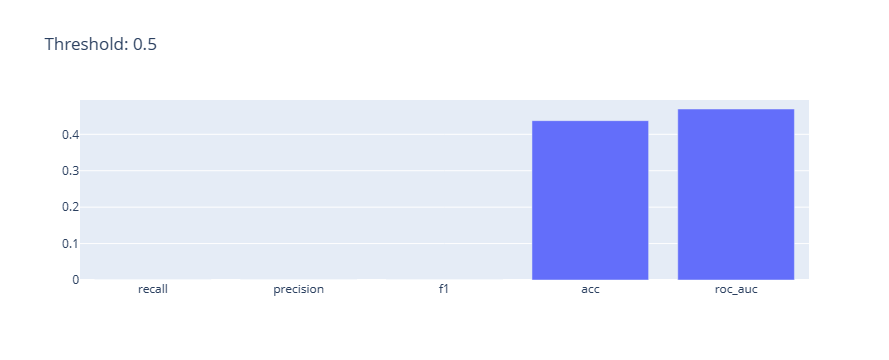

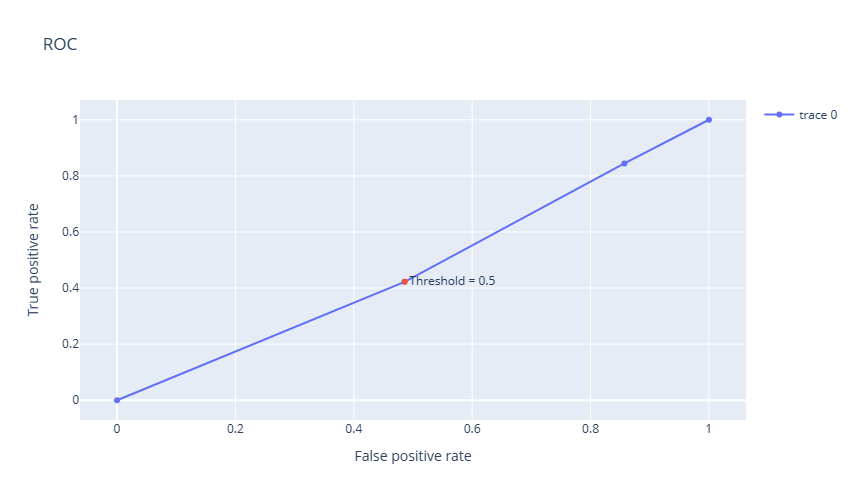

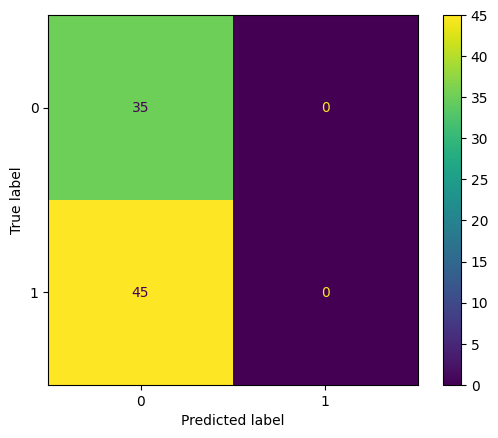

In [50]:
plot_metrics(detector_loaded, Stage.TEST).show()
draw_roc(detector_loaded, Stage.TEST).show()
plot_confusion_matrix(detector_loaded, Stage.TEST)